# Assignment 8: Neural Networks and Backpropagation
In this assignment, you will be asked to write your own code to implement the learning process of a simple neural network. We will use a simple version of [MNIST dataset](http://yann.lecun.com/exdb/mnist/), which we have introduced in Assignment 6. To make the problem simpler, we only take images with label '8' and '9', which gives us a binary classification problem. Then we subsample the dataset and reduce the dimension of each image using average pooling. The following code loads the dataset and prints its dimension.

Similar to Assignment 3, you will need to implement forward and back-propagation. We define the following terms:

$n$ - the dataset size. For the training set $n=964$

$d$ - feature dimension. In this dataset $d=196$

$X\in\mathbb{R}^{d\times n}$ - the dataset written in a $d\times n$ matrix where the $i$-th column is the feature vector $x_i\in\mathbb{R}^d$ of data $i$.

$Y\in\{0, 1\}^n$ - the labels of all data.


In [87]:
import numpy as np 
import matplotlib.pyplot as plt
#Load data
import scipy.io as sio
a = sio.loadmat('mnist_binary.mat')
X_trn = a['X_trn']
X_tst = a['X_tst']
Y_trn = a['Y_trn'][0]
Y_tst = a['Y_tst'][0]
print(X_trn.shape)
print(X_tst.shape)
print(Y_trn.shape)
print(Y_tst.shape)

(196, 964)
(196, 414)
(964,)
(414,)


## Requirements
1. You are not allowed to use any machine learning libraries which have neural networks implemented.

2. Notice here most of the problems you have will be regarding the dimensions of variables. In each skeleton function we provide, we have one assert line to help you verify whether you write your code correctly. Passing the assert line doesn't mean your code is correct. But it is a necessary condition.

3. You don't need to strictly follow the skeleton we provide. As long as you answer the problems correctly, you can write in any style you prefer.

## Parameters
Let's first implement a simple neural network with one hidden layer and one output layer. The hidden layer only has $n_h$ neurons. We assume the output layer has two neurons. Hence you will have 4 parameters to describe the neural network: 

1. $W_1$, a $n_h$ by $d=196$ matrix, which is the weight matrix between features and the hidder layer.
2. $b_1\in\mathbb{R}^{n_h}$, which is the offset for the first layer.
3. $W_2$, a 2 by $n_h$ matrix, which is the weight matrix between the hidder layer and the output layer.
4. $b_2\in\mathbb{R}^2$, which is the offset for the second layer.

The following script initializes the above four parameters and returns them as a dictionary.

In [2]:
#Initialize parameters 
num_hidden = 20 #number of neurons in the hidden layer
num_op = 2 #number of neurons in the output layer

def initialize_parameters(size_input, size_hidden, size_output):
    np.random.seed(2)
    W1 = np.random.randn(size_hidden, size_input) * 0.01
    b1 = np.zeros(shape=(size_hidden, 1))
    W2 = np.random.randn(size_output, size_hidden) * 0.01
    b2 = np.zeros(shape=(size_output, 1))
    parameters = {'W1': W1,
                  'b1': b1,
                  'W2': W2,
                  'b2': b2}
    return parameters
parameters = initialize_parameters(X_trn.shape[0], num_hidden, num_op)
print('W1',parameters['W1'].shape)
print('b1',parameters['b1'].shape)
print('W2',parameters['W2'].shape)
print('b2',parameters['b2'].shape)

W1 (20, 196)
b1 (20, 1)
W2 (2, 20)
b2 (2, 1)


Denote the activation function as $\sigma$ which will be specified later. Given the i'th data $x_i\in \mathbb{R}^d$, the neural network produces an output $\hat{y}_i\in(0, 1)$ as follows: 
$$
Z_1^{(i)}=W_1x_i+b_1,
$$
$$
A_1^{(i)}=\sigma(Z_1^{(i)}),
$$
$$
Z_2^{(i)}=W_2A_1^{(i)}+b_2.
$$
$$
\hat{y}_i=A_2^{(i)}:=\text{Softmax}(Z_2^{(i)}).
$$
Note that the final layer does not have an activation. The first step is to implement the necessary functions needed for forward pass.

## Softmax function.
Let $Z_2=(z_1, z_2)$ be the final output layer of neurons. The softmax outputs are probability estimates for outputing label 1 (assuming '8' is 1 and '9' is zero):

$$\hat{y}_1 = \Pr(Y = 1 | z_1, z_2) = \frac{e^{z_1}}{e^{z_1} + e^{z_2}}$$

For time-efficiency, we want to perform computations for the entire dataset. Denote $Z_2=(Z_2^{(1)}, \ldots, Z_2^{(n)})$ which is a matrix of shape $2 \times n$, and each column $Z_2^{(i)}$ is assumed to be the output of the final layer of the neural network. Your output should be $A_2=(\hat{y}_i, \ldots, \hat{y}_n)$, which has shape $1 \times n$.

Write code in the cell below to do the softmax computation

In [280]:
def softmax(Z2):
    # ip - (M,N) array where M is no. of neurons in output layer, N is number of samples.
    # You can modify the code if your output layer is of different dimension
   # =========Write your code below ==============
    #print(Z2)
    softmax = np.zeros((1, Z2.shape[1]))
    #print(softmax.shape)
    
    for i in range(Z2.shape[1]):
        z = np.array([Z2[0][i],Z2[1][i]])
        exp_z = np.exp(z)
        sum_exp_z = np.sum(exp_z)
        softmax[0,i] = exp_z[0] / sum_exp_z

    # =============================================
    assert(softmax.shape == (1, Z2.shape[1]))
    return softmax

In [277]:
Z = np.array([[0.3,2,3,4],
              [0.5,2,3,4]])
softmax(Z)

(1, 4)


array([[0.450166, 0.5     , 0.5     , 0.5     ]])

## Activation function.
The following function should be able to implement activation function given the input. An activation function is a one-variable real-valued function denoted as $\sigma:\mathbb{R}\mapsto \mathbb{R}$. For notation simplicity, given a matrix $A$, we denote $\sigma(A)$ as applying the function $\sigma$ to each element of $A$, i.e., $\sigma(A)$ is a matrix with the same dimension as $A$ where each element is defined as
$$
\sigma(A)_{ij}:=\sigma(A_{ij})
$$

Complete the activation function below. We will use $\text{ReLU}$ and $\text{Sigmoid}$ as our activation functions where for $x\in\mathbb{R}$, 
$$
\text{ReLU}(x)=\max\{0, x\},\quad \text{Sigmoid}(x)=\frac{1}{1+e^{-x}}
$$

In [362]:
import math
def activ(ip,act):
    # ip - array obtained after multiplying inputs with weights (between input layer and hidden layer)
    # act - ReLU or Sigmoid
    out = np.zeros((ip.shape[0], ip.shape[1]))
    if act =="ReLU":
        # =========Write your code below ==============
        for i in range(ip.shape[0]):
            for j in range(ip.shape[1]):
                if ip[i][j]>0:
                    out[i][j]=ip[i][j]


    # =============================================
    elif act == "Sigmoid":
        # =========Write your code below ==============
        out = 1.0 / (1.0+np.exp(-ip))
    else:
        print("...avtive function error...")
    # =============================================
    assert(out.shape == ip.shape)
    return out

In [ ]:
ip = np.array( [ [-1,2,3,6],
                 [-2,3,4,6],
                 [-5,6,7,6] ] )
activ(ip,"ReLU")

## Forward Propagation
Given $X, W_1, b_1, W_2, b_2$, the following function will compute the neurons and activated values in the hidden layer, denoted by $Z_1, A_1$ respectively. $Z_1, A_1$ are defined similarly as $Z_2$,
$$
Z_1=(Z_1^{(1)}, \ldots, Z_1^{(n)}), \quad A_1=(A_1^{(1)}, \ldots, A_1^{(n)})
$$
It will also return the neurons in the last layer and the softmax function computed from it, denoted by $Z_2, A_2$ respectively. 

In [365]:
#Forward Propagation   
def forward_propagation(X, parameters, act):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
# =========Write your code below ==============
    
    Z1 = np.dot(W1,X)+b1
    A1 = activ(Z1,act)
    #print(A1)
    Z2 = np.dot(W2,A1)+b2
    A2 = softmax(Z2)
    # =============================================
    #print(A2.shape)
    assert(A2.shape == (1, X.shape[1]))
    
    neuron = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    return neuron

In [366]:
neuron = forward_propagation(X_trn, parameters, "Sigmoid")
neuron['A1'].shape

(20, 964)

## Backward propagation
In this assignment, we will use the cross-entropy loss defined below as our loss function. Suppose that for data $x\in \mathbb{R}$, $Z=(z_1, z_2)$ is the final layer of neurons, and after softmax we obtain $\hat{y}$ which corresponds to the probability of label 8. Let $y$ be the true labels (assume 1 for '8', 0 for '9')
$$\ell(y,\hat{y}) = -y\log(\hat{y}) - (1-y_i)\log(1-\hat{y}),$$
where $$\hat{y} = \text{Softmax}(Z)=\frac{e^{z_1}}{e^{z_1} + e^{z_2}}.$$

You have shown in the assignment that:
$$\frac{\partial \ell(y,\hat{y})}{\partial z_1} = \hat{y} - y, \frac{\partial \ell(y,\hat{y})}{\partial z_2} = y - \hat{y}.$$

Similar to the logistic regression assignment, during training we wish to minimize the following loss function,
$$
L(X, Y; \theta)=\frac{1}{n}\sum_{i=1}^n\ell(y_i, \hat{y}_i).
$$
Given the parameters and the neuron values, we wish to calculate the gradient of the loss function w.r.t all the parameters $W_1, b_1, W_2, b_2$ using backward propagation. Note here, all the gradients should be of the same dimension as the corresponding parameters. 

In [381]:
def backprop(parameters, neuron, X, Y, act):
    W1 = parameters['W1']
    W2 = parameters['W2']
    b1 = parameters['b1']

    A1 = neuron['A1']
    A2 = neuron['A2']
    Z1 = neuron['Z1']
    Z2 = neuron['Z2']
# =========Write your code below ==============
    delta = 1e-7
    dZ2 = np.zeros((Z2.shape[0],Z2.shape[1]))
    Y = Y.reshape((1,Y.shape[0]))
    #predict = (A2 >0.5) *1
    loss = cross_entropy_loss(A2, Y)
    
    dZ2[0] = A2 - Y
    dZ2[1] = Y - A2
                
    #dZ2 = loss * dZ2 
    dW2 = np.dot(dZ2, A1.T)
    #print("dz2 shape",dZ2.shape)
    db2 = np.sum(dZ2.T, axis = 0)
    db2 = db2.reshape((db2.shape[0],1))
    
    dA1 = np.dot(W2.T, dZ2)
    
    if act == "Sigmoid":
        dZ1 = dA1 * A1*(1-A1)
    elif act == "ReLU":
        mask = A1>0
        dZ1 = dA1 * mask
    dW1 = np.dot(dZ1, X.T)
    db1 = np.sum(dZ1.T, axis = 0)
    db1 = db1.reshape((db1.shape[0],1))

    ##divide the gradients by the number of samples
    dW1 = dW1 / Y.shape[0]
    dW2 = dW2 / Y.shape[0]
    db1 = db1 / Y.shape[0]
    db2 = db2 / Y.shape[0]
    
    # =============================================
    
    assert(dW1.shape == W1.shape)
    assert(dW2.shape == W2.shape)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads
print(backprop(parameters, neuron, X_trn, Y_trn, act='Sigmoid')['dW1'].shape)
print(backprop(parameters, neuron, X_trn, Y_trn, act='Sigmoid')['dW2'].shape)
print(backprop(parameters, neuron, X_trn, Y_trn, act='Sigmoid')['db1'].shape)
print(backprop(parameters, neuron, X_trn, Y_trn, act='Sigmoid')['db2'].shape)

def cross_entropy_loss(softmax, Y):
# =========Write your code below ==============
    delta = 1e-7 
    loss = np.log(softmax+delta)*(-Y) - (1-Y)*np.log(1-softmax+delta)
# =============================================        
    assert(loss.shape == Y.shape)
    return loss

(20, 196)
(2, 20)
(20, 1)
(2, 1)


## Parameter updates
Given the parameters and the gradients, we simply update the parameters by the following:

$$W = W - \eta dW$$

where $\eta$ is the learning rate.

In [368]:
def update_parameters(parameters, grads, learning_rate):

# =========Write your code below ==============
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    A1 = neuron['A1']
    A2 = neuron['A2']
    b1 = parameters['b1']
    b2 = parameters['b2']
    
    W1 = W1-learning_rate * grads['dW1'] 
    W2 = W2-learning_rate * grads['dW2']
    b1 = b1-learning_rate * grads['db1']
    b2 = b2-learning_rate * grads['db2']
    
# =============================================

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [ ]:
W = np.array([])

## Neural network models
Combining the above mentioned parameters, implement the following function to learn a neural network and do inference on it. Given a predicted probability $\hat{y}$, obtain a predicted label in $\{0, 1\}$ by comparing $\hat{y}$ to 1/2.

In [369]:
result = (np.array([0.6,0.56,0.4]) > 0.5) * 1
print(result)
a = np.array([1,2,3])
a = np.square(a)
print(Y_trn.shape[0])

[1 1 0]
964


In [390]:
from sklearn.metrics import accuracy_score
def nn_model1(X_trn, X_tst, Y_trn, Y_tst, n_h, n_o, epochs, act, learning_rate):
    #X_trn: the training set
    #X_tst: the test set
    #Y_trn: training labels
    #Y_tst: test labels
    #n_h: number of neurons in the hidden layer
    #n_o: number of neurons in the output layer
    #epochs: number of epochs for the training
    #act: the activation function you choose
    #learning_rate: a list of length epochs, which consists of the learning rate in each step
    
    assert(len(learning_rate) == epochs)
    
   # =========Write your code below ==============
    err_tst = np.zeros(epochs)
    err_trn = np.zeros(epochs)
    loss_trn = np.zeros(epochs)
    parameters = initialize_parameters(X_trn.shape[0], n_h, n_o)
    
    for i in range(epochs):
        #print(i,"epoch")
        ## training data
        neuron = forward_propagation(X_trn, parameters, act)
        predict = (neuron['A2'] >0.5) *1 ##predicted label in {0,1}
        err_trn[i] = np.sum(np.square(predict - Y_trn)) / Y_trn.shape[0]
        
        Y_trn_l = Y_trn.reshape((1,Y_trn.shape[0]))
        l = cross_entropy_loss(neuron['A2'], Y_trn_l)
        l=np.sum(l)
        loss_trn[i] = l/Y_trn.shape[0]
        
        ##testing data
        neuron_tst = forward_propagation(X_tst, parameters, act)
        predict_tst = (neuron_tst['A2'] > 0.5) *1
        err_tst[i] = np.sum(np.square(predict_tst - Y_tst)) / Y_tst.shape[0]
        
        grads = backprop(parameters, neuron, X_trn, Y_trn, act)
        parameters = update_parameters(parameters, grads, learning_rate[i])
        

    # =============================================    
    #err_tst: testing error (classification error) in each epoch
    #err_trn: training error (classification error) in each epoch
    #loss_trn: training loss (cross entropy loss) in each epoch
    #parameters: the final learned parameters
    return err_tst, err_trn, loss_trn, parameters

## Problem 0: Verify that your code is working well.
Using ReLU (Sigmoid) as your activation function, implement a learning algorithm with fixed learning rate $\eta = 0.01$ at each step. Set the number of epochs to be 20000. Plot the cross entropy loss at each epoch to convince yourself that you are training well. (Your cross entropy loss should be decreasing smoothly. This part won't be graded.)

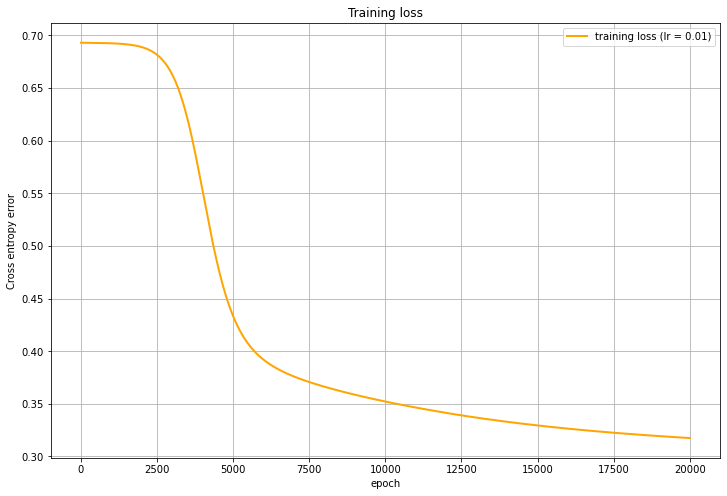

In [392]:
#epochs = 20000
epochs = 20000
lr1 = 0.01*np.ones(epochs)
# =========Write your code below ==============
lr1 = lr1/1000
err_tst, err_trn, loss_trn, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, 20, 2, epochs, 'ReLU', lr1)



# =============================================
plt.figure(1, figsize=(12, 8))
plt.plot(range(epochs), loss_trn, '-', color='orange',linewidth=2, label='training loss (lr = 0.01)')
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('Cross entropy error')
plt.legend(loc='best')
plt.grid()
plt.show()

# Problem 1: Learning with fixed learning rate.
Using ReLU as your activation function, implement a learning algorithm with fixed learning rate $\eta = 0.01$ at each step. Plot the training and testing error (classification error) you get at each epoch. Justify your plot. (Set the number of hidden neurons in the hidden layer to be 20 for problem 1-3, for all problems below, set epochs = 20000).

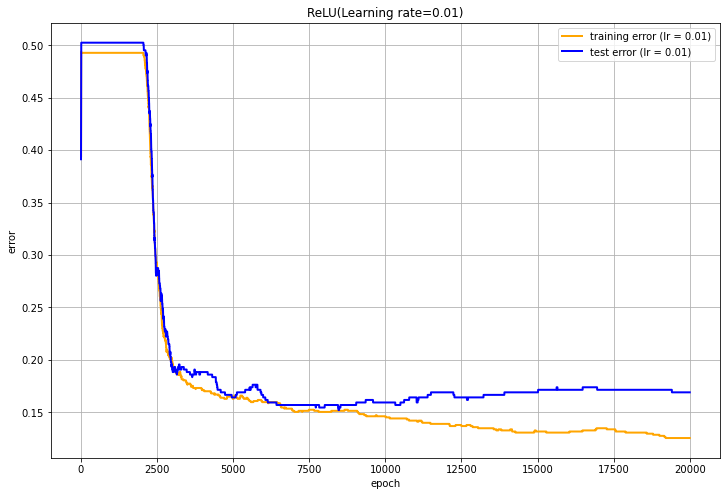

In [393]:
epochs = 20000
lr1 = 0.01*np.ones(epochs)

# =========Write your code below ==============
lr1 = lr1/1000
err_tst, err_trn, loss_trn, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, 20, 2, epochs, 'ReLU', lr1)




# =============================================
plt.figure(1, figsize=(12, 8))
plt.plot(range(epochs), err_trn, '-', color='orange',linewidth=2, label='training error (lr = 0.01)')
plt.plot(range(epochs), err_tst, '-b', linewidth=2, label='test error (lr = 0.01)')
#plt.plot(range(epochs), trn_loss, '-r', linewidth=2, label='loss (lr = 0.01)')

plt.title('ReLU(Learning rate=0.01)')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid()
plt.show()

At the beggining of the plot, both the training error and testing error does not decrease. The reason is that the learning rate is small, so the model takes some steps to get the right direction to decrease the error. 

# Problem 2: 
Using ReLU as your activation function, change the learning rate to $\eta = 0.1$. Plot the plots on the same figure as in problem 1. Compare the plots and justify.

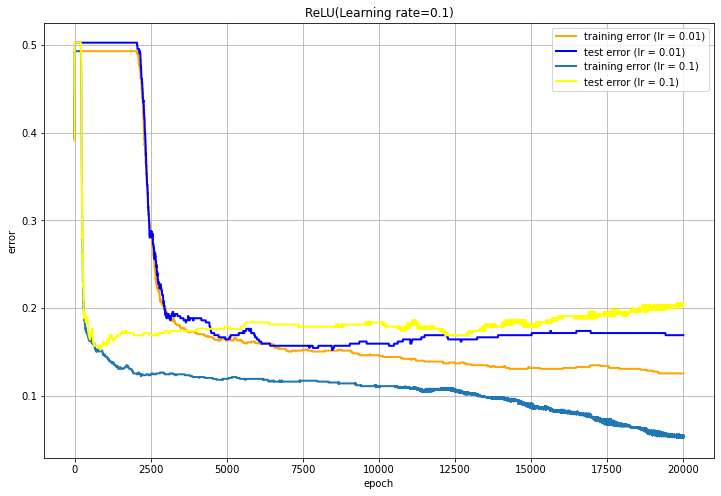

In [396]:
lr2 = 0.1*np.ones(epochs)
# =========Write your code below ==============
lr2 = lr2/1000
err_tst2, err_trn2, loss_trn, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, 20, 2, epochs, 'ReLU', lr2)




# =============================================
plt.figure(2, figsize=(12, 8))
# Classification errors for learning rate = 0.01, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn, '-', color='orange',linewidth=2, label='training error (lr = 0.01)')
plt.plot(range(epochs), err_tst, '-b', linewidth=2, label='test error (lr = 0.01)')

# Classification errors for learning rate = 0.1, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn2, '-', linewidth=2, label='training error (lr = 0.1)')
plt.plot(range(epochs), err_tst2, '-b', color='yellow', linewidth=2,  label='test error (lr = 0.1)')

plt.title('ReLU(Learning rate=0.1)')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid()
plt.show()

Compared to the result from problem1, the reult in this part shows that the error decrease very quickly. However, the testing error is worse. This is beacause that with a larger learning rate, the model will learn faster but loss the ability to tune the weight with high percision.

# Problem 3: Learning with variable learning rate.
Using ReLU as your activation function, implement a learning algorithm with variable learning rate $\eta = \frac1{\sqrt{i+1}}$ at the $i$th step. Plot the training and testing error you get at each iteration and compare it with the plots you get previously. Justify your plot.

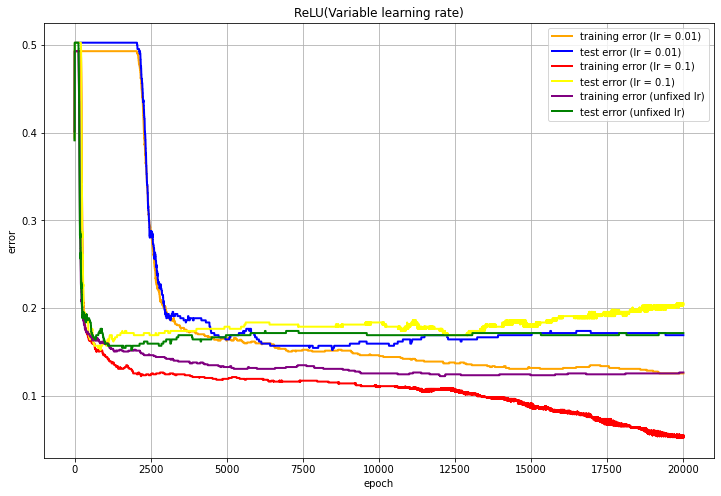

In [400]:
indices = np.array(range(epochs))
lr3 = 1/np.sqrt(indices + 1)
# =========Write your code below ==============
lr3 = lr3/1000

err_tst3, err_trn3, loss_trn, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, 20, 2, epochs, 'ReLU', lr3)


# =============================================
plt.figure(3, figsize=(12, 8))
# Classification errors for learning rate = 0.01, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn, '-', color='orange',linewidth=2, label='training error (lr = 0.01)')
plt.plot(range(epochs), err_tst, '-b', linewidth=2, label='test error (lr = 0.01)')

# Classification errors for learning rate = 0.1, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn2, '-', color='red', linewidth=2, label='training error (lr = 0.1)')
plt.plot(range(epochs), err_tst2, '-b', color='yellow', linewidth=2, label='test error (lr = 0.1)')

# Classification errors for variable learning rate, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn3, '-', color='purple', linewidth=2, label='training error (unfixed lr)')
plt.plot(range(epochs), err_tst3, '-b', color='green', linewidth=2, label='test error (unfixed lr)')
plt.title('ReLU(Variable learning rate)')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid()
plt.show()

The result shows that, with an unfixed learning rate, it has the advantages both from the models of problem 1 and problem2. When the learning rate is big at first and then decrease with the training process, the model can learn faster at first and tune the parameters finely. In other words, it can imporve the efficiency of learning and avoid overfitting. 

# Problem 4: Larger hidden layer.
Change the number of neurons in the hidden layer to be $50$. Redo the experiment in problem 1. Plot all four plots in the same figure and justify your plot.

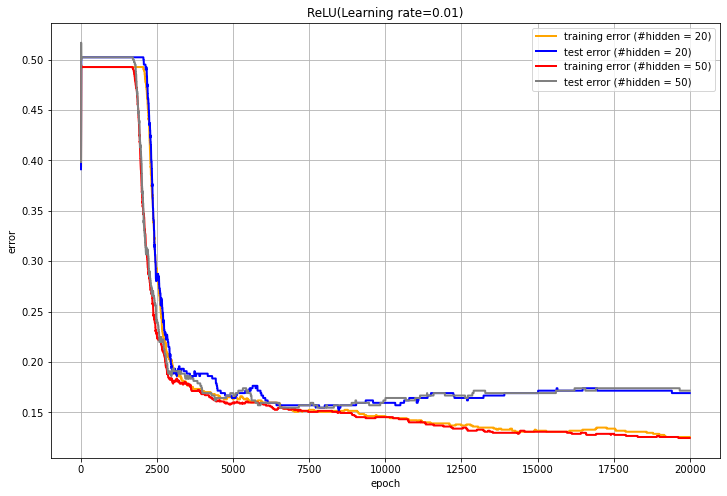

In [398]:
num_hidden2 = 50
# =========Write your code below ==============

err_tst4, err_trn4, loss_trn, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, 50, 2, epochs, 'ReLU', lr1)

# =============================================
plt.figure(4, figsize=(12, 8))
# Classification errors for learning rate = 0.01, Relu Activation, n_hidden = 20
plt.plot(range(epochs), err_trn, '-', color='orange',linewidth=2, label='training error (#hidden = 20)')
plt.plot(range(epochs), err_tst, '-b', linewidth=2, label='test error (#hidden = 20)')

# Classification errors for learning rate = 0.01, Relu Activation, n_hidden = 50
plt.plot(range(epochs), err_trn4, '-', color='red', linewidth=2, label='training error (#hidden = 50)')
plt.plot(range(epochs), err_tst4, '-b', color='grey', linewidth=2, label='test error (#hidden = 50)')

plt.title('ReLU(Learning rate=0.01)')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid()
plt.show()

The model with a larger hidden layer has a better perfromance(less traning and testing error). This shows that, with a larger hidden layer, the model can become more complex and then fit in the dataset better.

# Problem 5: Sigmoid Activation.
Change the activation function to be Sigmoid function. Redo the experiment in problem 1. Plot all four plots in the same figure and justify your plot.

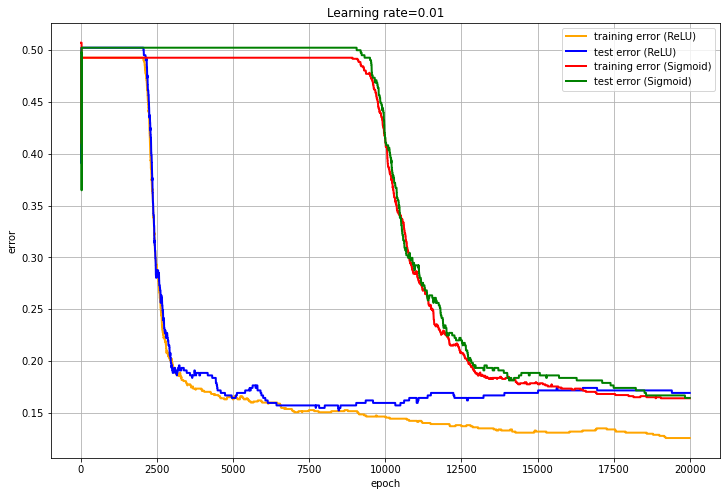

In [399]:
# =========Write your code below ==============
err_tst, err_trn, loss_trn, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, 20, 2, epochs, 'ReLU', lr1)
err_tst5, err_trn5, loss_trn, parameters = nn_model1(X_trn, X_tst, Y_trn, Y_tst, 20, 2, epochs, 'Sigmoid', lr1)

# =============================================
# Classification errors for learning rate = 0.01, Relu Activation, n_hidden = 20
plt.figure(5, figsize=(12, 8))
plt.plot(range(epochs), err_trn, '-', color='orange',linewidth=2, label='training error (ReLU)')
plt.plot(range(epochs), err_tst, '-b', linewidth=2, label='test error (ReLU)')

# Classification errors for learning rate = 0.01, Sigmoid Activation, n_hidden = 20
plt.plot(range(epochs), err_trn5, '-', color='red',  linewidth=2, label='training error (Sigmoid)')
plt.plot(range(epochs), err_tst5, '-b', color='green', linewidth=2, label='test error (Sigmoid)')

plt.title('Learning rate=0.01')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid()
plt.show()

The result shows that when the active function is sigmoid, it takes more epochs to learn the right direction. I believe that this is because the backpropagation of ReLU has a more sharp reaction toward the right direction for this dataset. 